The PPMI repository contains the full set of clinical, imaging and biological data collected as part of this ongoing study along with processed images and biospecimen analysis results. The repository is updated regularly as longitudinal follow-up of study subjects continues and data generated from a variety of CSF, DNA, serum, plasma and RNA analysis techniques are completed.

# Setup and Libraries

In [29]:
# Cell 0: get current notebook path, its parent, and project root (parent of parent)
import os
from pathlib import Path

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: improve plots appearance
sns.set(style="whitegrid")

ROOT_DIR = Path(os.getcwd()).resolve().parents[1]


# Load the CSV and parse Imaging Protocol

In [30]:
CSV_DIR = ROOT_DIR / "csv_dir"
original_df = pd.read_csv(CSV_DIR / "BLSA_idaSearch_ALL.csv")


# little adjustments
original_df["Subject ID"] = original_df["Subject ID"].astype("category")
original_df["Image ID"] = original_df["Image ID"].astype("category")
original_df["Weight"] = original_df["Weight"].replace(0, np.nan)
original_df["Age"] = original_df["Age"].replace(0, np.nan)
original_df["Study Date"] = pd.to_datetime(original_df["Study Date"], errors="coerce")

print(original_df.columns)
print(len(original_df))

fields = [
    "Acquisition Plane",
    "Slice Thickness",
    "Matrix Z",
    "Acquisition Type",
    "Manufacturer",
    "Mfg Model",
    "Field Strength",
    "Weighting",
]

numeric_fields = ["Slice Thickness", "Matrix Z", "Field Strength"]


def parse_imaging_protocol(text):
    if pd.isna(text):
        return {}

    items = text.split(";")
    parsed = {}

    for item in items:
        if "=" in item:
            key, value = item.split("=", 1)
            parsed[key.strip()] = value.strip()

    return parsed


# Parse the column into dictionaries
protocol_parsed = original_df["Imaging Protocol"].apply(parse_imaging_protocol)

# Create new columns
for field in fields:
    original_df[field] = protocol_parsed.apply(lambda x: x.get(field, np.nan))


for field in numeric_fields:
    original_df[field] = pd.to_numeric(original_df[field], errors="coerce")

print(original_df.columns)

Index(['Subject ID', 'Project', 'Sex', 'Weight', 'Visit', 'Archive Date',
       'Study Date', 'Age', 'Modality', 'Description', 'Type',
       'Imaging Protocol', 'Image ID'],
      dtype='object')
1056
Index(['Subject ID', 'Project', 'Sex', 'Weight', 'Visit', 'Archive Date',
       'Study Date', 'Age', 'Modality', 'Description', 'Type',
       'Imaging Protocol', 'Image ID', 'Acquisition Plane', 'Slice Thickness',
       'Matrix Z', 'Acquisition Type', 'Manufacturer', 'Mfg Model',
       'Field Strength', 'Weighting'],
      dtype='object')


# Filtered dataframe

### Basic filter

In [31]:
# Apply filters

df = original_df[
    (original_df["Modality"] == "MRI")
    # & (original_df["Weighting"] == "T1")
    # & (original_df["Matrix Z"] > 100)
    # & (original_df["Slice Thickness"] < 1.4)
    # & (original_df["Acquisition Type"] == "3D")
    # & (original_df["Type"] == "Original")
].copy()

print(
    f"Filtered dataset size: {df.shape[0]} images from {df['Subject ID'].nunique()} subjects."
)
df["Description"].unique()


Filtered dataset size: 1056 images from 118 subjects.


array(['FLAIR', 'DE_ADNIaxial', 'MPrageADNIsag', 'DTIHR2.2'], dtype=object)

### more advanced

In [32]:
# # Apply filters
# weighting_filter = (original_df["Weighting"] == "T1") | (
#     (original_df["Weighting"] == "PD")
#     & original_df["Description"].str.contains("T1", case=False, na=False)
# )

# df = original_df[
#     (original_df["Modality"] == "MRI")
#     & weighting_filter
#     & (original_df["Matrix Z"] > 100)
#     & (original_df["Slice Thickness"] < 1.4)
#     & (original_df["Acquisition Type"] == "3D")
#     # & (original_df["Type"] == "Original")
# ].copy()

# print(
#     f"Filtered dataset size: {df.shape[0]} images from {df['Subject ID'].nunique()} subjects."
# )

### No filter

In [33]:
# df = original_df

In [34]:
df.head(2)

,Subject ID,Project,Sex,Weight,Visit,Archive Date,Study Date,Age,Modality,Description,...,Imaging Protocol,Image ID,Acquisition Plane,Slice Thickness,Matrix Z,Acquisition Type,Manufacturer,Mfg Model,Field Strength,Weighting
0,1004324,BLSA_OPEN,M,NaN,Visit 02,9/11/2024,2010-10-01,87.1,MRI,FLAIR,...,Acquisition Plane=AXIAL;Mfg Model=Achieva;Slic...,10942622,AXIAL,3.0,150.0,2D,Philips Medical Systems,Achieva,3.0,PD
1,1004324,BLSA_OPEN,M,NaN,Visit 02,3/14/2025,2010-10-01,87.1,MRI,DE_ADNIaxial,...,Acquisition Plane=AXIAL;Mfg Model=Achieva;Slic...,11156659,AXIAL,3.0,50.0,2D,Philips Medical Systems,Achieva,3.0,T2


# Basic descriptions

In [35]:
# -------------------------------
# Column Names
# -------------------------------
print("=== Columns in the Dataset ===")
display(pd.DataFrame(df.columns, columns=["Column Names"]))

# -------------------------------
# Summary of Numeric Features
# -------------------------------
print("\n=== Numeric Features Summary ===")
display(df.describe().round(2))  # round to 2 decimals

# -------------------------------
# Summary of Categorical Features
# -------------------------------
print("\n=== Categorical Features Summary ===")
display(df.describe(include=["object", "category"]))

# -------------------------------
# Missing Values
# -------------------------------
missing_count = df.isnull().sum()
missing_percent = (missing_count / len(df) * 100).round(2)
missing_df = pd.DataFrame(
    {"Missing Count": missing_count, "Missing %": missing_percent}
).sort_values(by="Missing Count", ascending=False)

print("\n=== Missing Values by Column ===")
display(missing_df)

# Find columns with at least one missing value
cols_with_missing = df.columns[df.isnull().any()]
print(f"Columns with missing values ({len(cols_with_missing)}):\n")

# for col in cols_with_missing:
#     print(f"--- {col} ---")
#     # Show up to 5 rows where this column is missing
#     display(df[df[col].isnull()].head(3))

=== Columns in the Dataset ===


,Column Names
0,Subject ID
1,Project
2,Sex
3,Weight
4,Visit
5,Archive Date
6,Study Date
7,Age
8,Modality
9,Description



=== Numeric Features Summary ===


,Weight,Study Date,Age,Slice Thickness,Matrix Z,Field Strength
count,0.0,1056,1056.00,1056.00,1056.00,1056.0
mean,NaN,2014-01-12 06:58:38.181818368,81.77,2.36,480.09,3.0
min,NaN,2009-03-01 00:00:00,46.50,1.20,50.00,3.0
25%,NaN,2011-10-01 00:00:00,78.20,1.20,50.00,3.0
50%,NaN,2014-02-01 00:00:00,83.60,3.00,150.00,3.0
75%,NaN,2016-02-01 00:00:00,86.70,3.00,170.00,3.0
max,NaN,2020-03-01 00:00:00,89.90,3.00,2380.00,3.0
std,NaN,NaN,6.53,0.78,849.94,0.0



=== Categorical Features Summary ===


,Subject ID,Project,Sex,Visit,Archive Date,Modality,Description,Type,Imaging Protocol,Image ID,Acquisition Plane,Acquisition Type,Manufacturer,Mfg Model,Weighting
count,1056,1056,1056,1056,1056,1056,1056,1056,1056,1056,1056,1044,1056,1056,1056
unique,118,1,2,30,7,1,4,1,14,1056,2,2,1,1,3
top,1666036,BLSA_OPEN,M,Visit 04,3/14/2025,MRI,MPrageADNIsag,Original,Acquisition Plane=SAGITTAL;Mfg Model=Achieva;S...,10942622,AXIAL,2D,Philips Medical Systems,Achieva,PD
freq,38,1056,681,79,293,1056,295,1056,290,1,761,754,1056,1056,468



=== Missing Values by Column ===


,Missing Count,Missing %
Weight,1056,100.00
Acquisition Type,12,1.14
Subject ID,0,0.00
Sex,0,0.00
Project,0,0.00
Visit,0,0.00
Archive Date,0,0.00
Age,0,0.00
Study Date,0,0.00
Description,0,0.00


Columns with missing values (2):



# Histograms

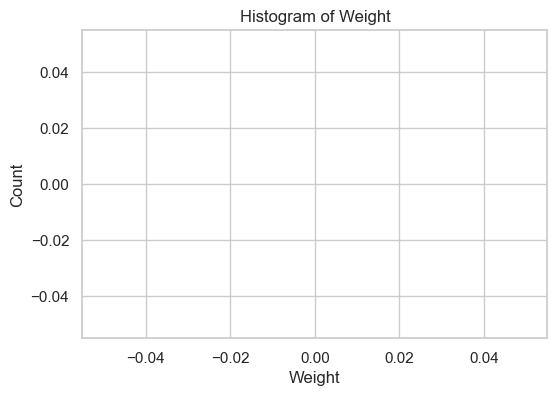

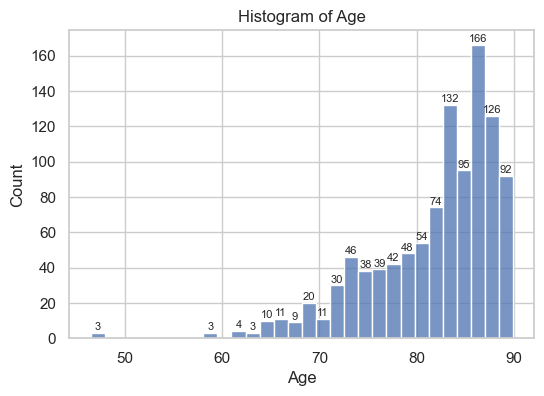

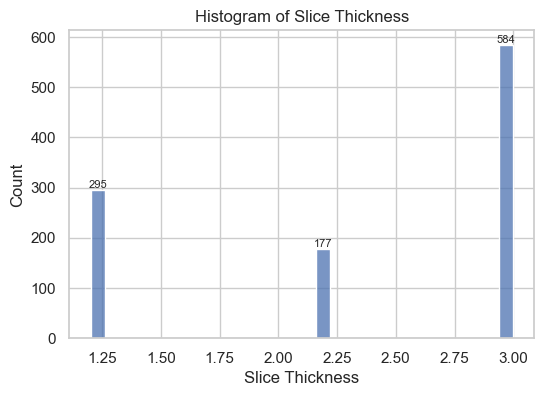

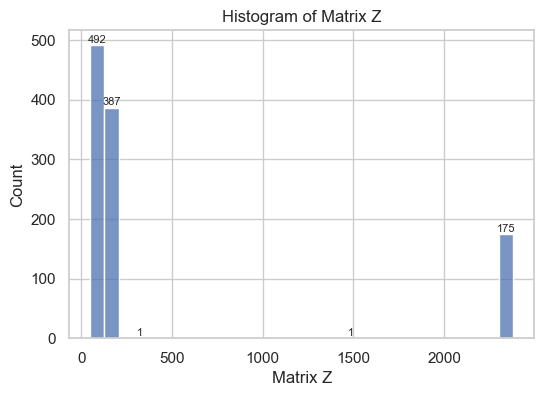

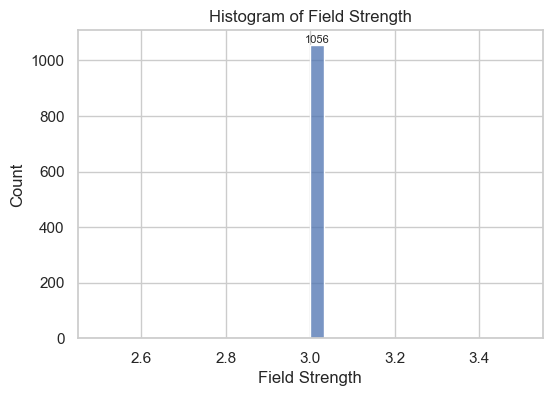

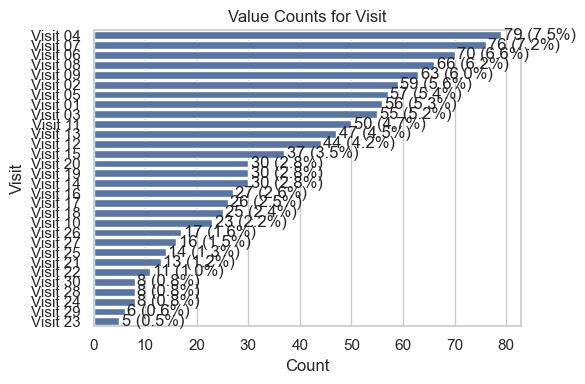

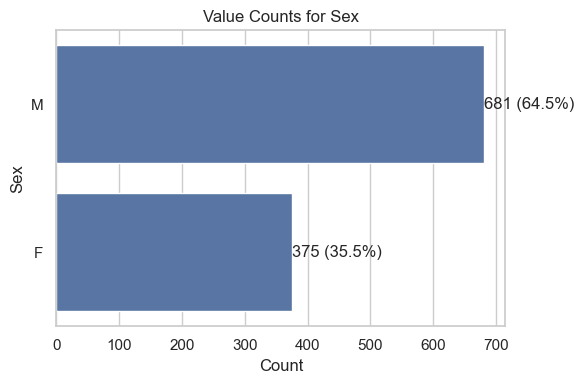

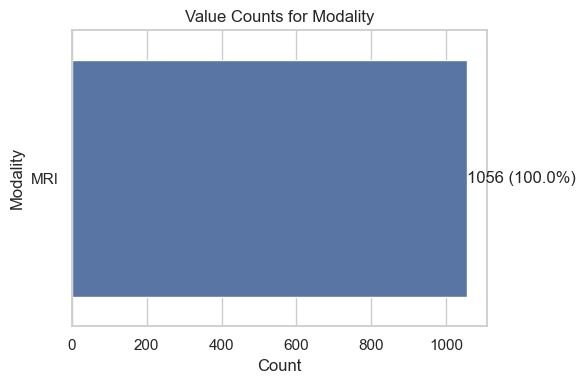

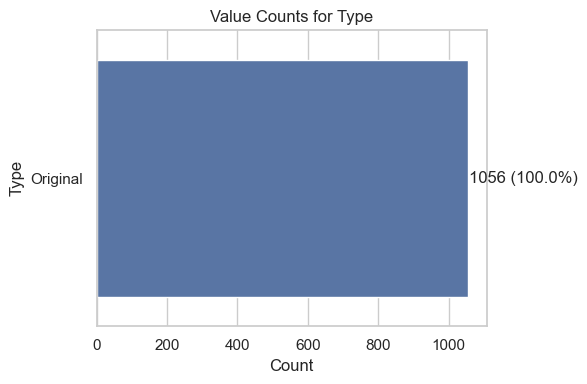

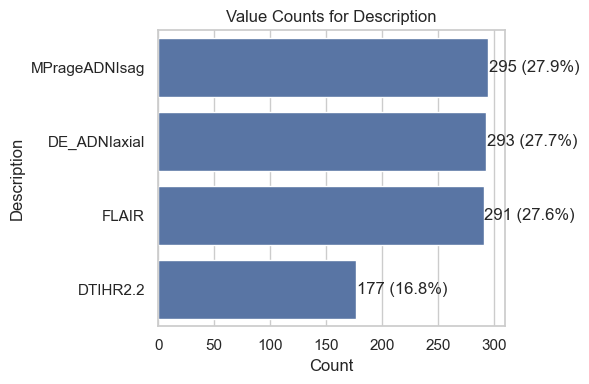

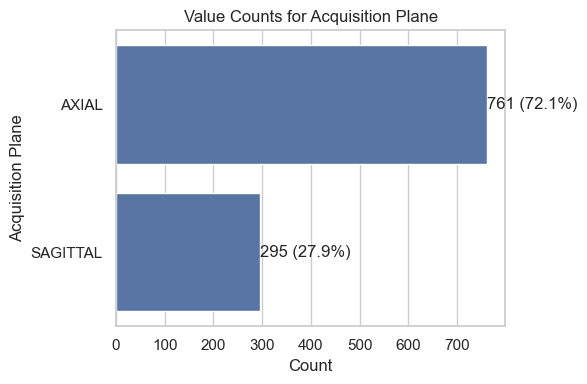

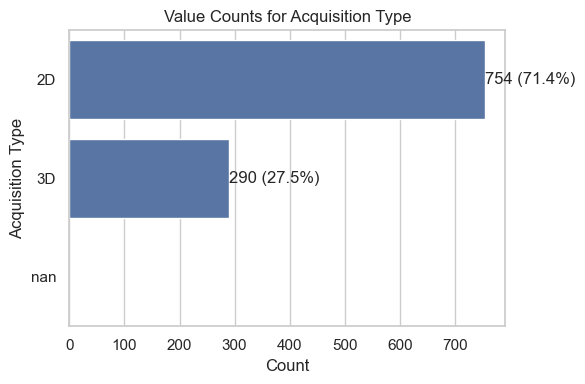

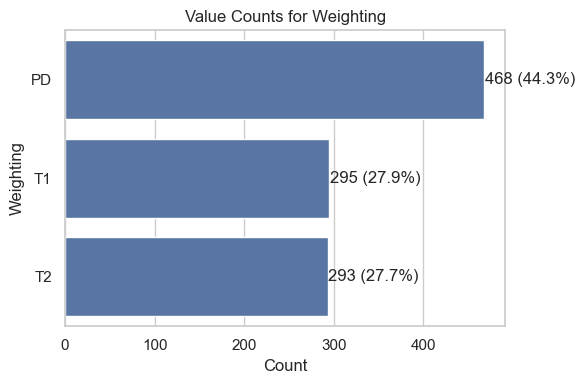

In [36]:
# Separate numeric and categorical columns
numeric_cols = df.select_dtypes(include=np.number).columns
categorical_cols = df.select_dtypes(include=["object", "category"]).columns

# -------------------------------
# Numeric Columns Histograms
# -------------------------------
for col in numeric_cols:
    plt.figure(figsize=(6, 4))

    # Plot histogram
    ax = sns.histplot(
        df[col].dropna(), bins=30, kde=False
    )  # disable KDE for counts clarity

    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")

    # Annotate counts on top of each bin
    for patch in ax.patches:
        height = patch.get_height()
        if height > 0:  # only annotate non-empty bins
            ax.text(
                patch.get_x() + patch.get_width() / 2,  # center of bin
                height + 0.5,  # slightly above the bar
                int(height),  # show integer count
                ha="center",
                va="bottom",
                fontsize=8,
            )

    plt.show()

# -------------------------------
# Categorical Columns Bar Plots
# -------------------------------
categorical_cols = [
    "Visit",
    "Sex",
    "Research Group",
    "Modality",
    "Type",
    "Structure",
    "Laterality",
    "Image Type",
    "Registration",
    "Description",
    "Tissue",
    # Imaging Protocol–derived categorical columns
    "Acquisition Plane",
    "Acquisition Type",
    # "Manufacturer",
    # "Mfg Model",
    "Weighting",
]

categorical_cols = [col for col in categorical_cols if col in df.columns]
for col in categorical_cols:
    plt.figure(figsize=(6, 4))

    counts = df[col].value_counts(dropna=False)
    total = counts.sum()
    order = counts.index

    ax = sns.countplot(y=col, data=df, order=order)

    # Add count + percentage labels
    for p, category in zip(ax.patches, order):
        count = counts[category]
        percent = 100 * count / total

        ax.text(
            p.get_width() + 0.5,
            p.get_y() + p.get_height() / 2,
            f"{count} ({percent:.1f}%)",
            va="center",
        )

    plt.title(f"Value Counts for {col}")
    plt.xlabel("Count")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()


# Study dates

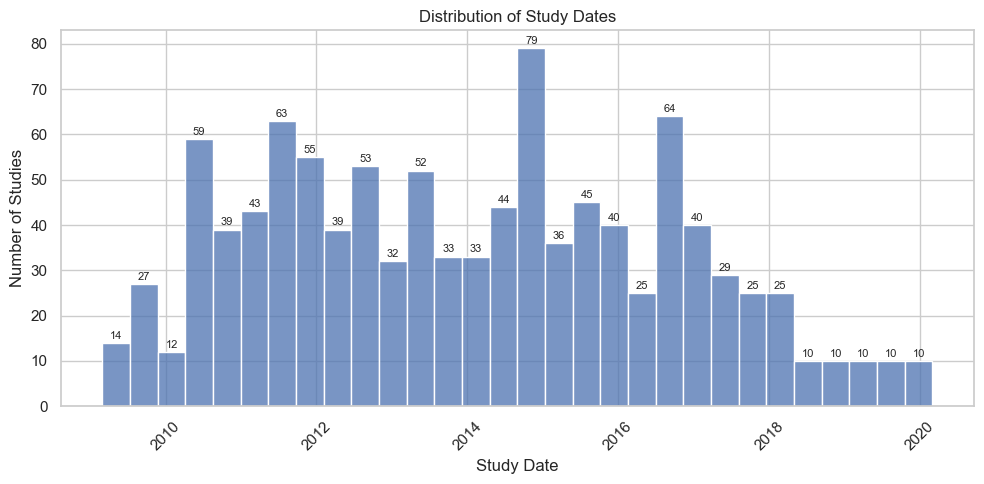

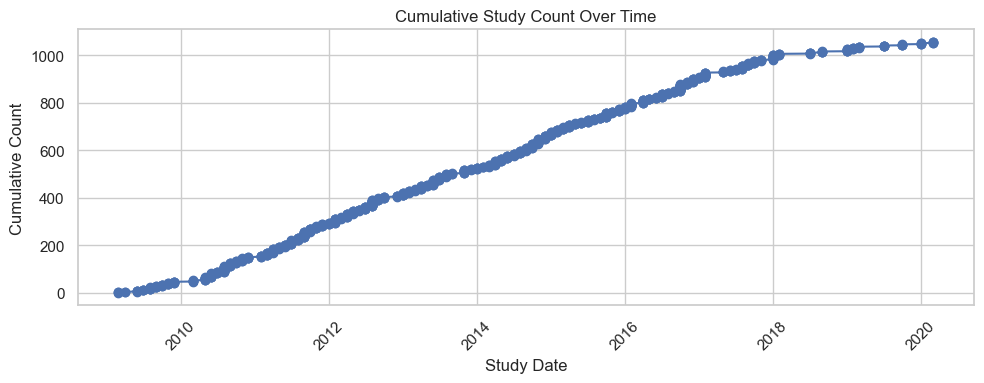

In [37]:
# -------------------------------
# Study Date Distribution
# -------------------------------


plt.figure(figsize=(10, 5))

# Histogram of study dates
ax = sns.histplot(df["Study Date"].dropna(), bins=30, kde=False)

plt.title("Distribution of Study Dates")
plt.xlabel("Study Date")
plt.ylabel("Number of Studies")

# Annotate counts on top of each bin
for patch in ax.patches:
    height = patch.get_height()
    if height > 0:
        ax.text(
            patch.get_x() + patch.get_width() / 2,
            height + 0.5,
            int(height),
            ha="center",
            va="bottom",
            fontsize=8,
        )

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# cumulative study count over time
plt.figure(figsize=(10, 4))
df_sorted = df.sort_values("Study Date")
df_sorted["Cumulative Count"] = range(1, len(df_sorted) + 1)
plt.plot(
    df_sorted["Study Date"], df_sorted["Cumulative Count"], marker="o", linestyle="-"
)
plt.title("Cumulative Study Count Over Time")
plt.xlabel("Study Date")
plt.ylabel("Cumulative Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Scans per session / coverage

Does a subject have more than one scan at a given visit?

How often does this happen?

In [38]:
df["Visit"] = df["Visit"].astype(str)

# scans per subject per visit
scans_per_subject_visit = (
    df.groupby(["Subject ID", "Visit"], observed=True)
    .size()
    .reset_index(name="n_scans")
)
# Keep only rows with at least 1 scan
scans_per_subject_visit = scans_per_subject_visit[
    scans_per_subject_visit["n_scans"] > 0
].copy()
# print(scans_per_subject_visit.head())
# print(scans_per_subject_visit["n_scans"].min())  # should now be >= 1


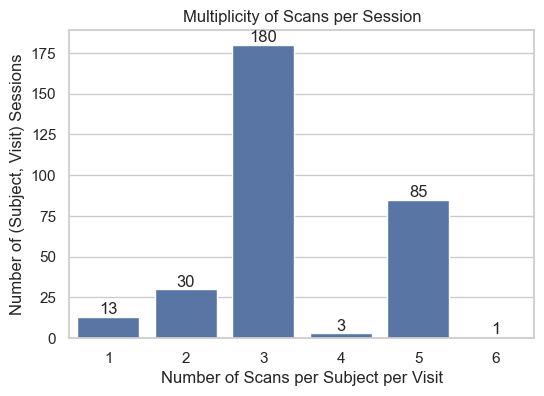

In [39]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(
    x="n_scans",
    data=scans_per_subject_visit,
    order=sorted(scans_per_subject_visit["n_scans"].unique()),
)

plt.xlabel("Number of Scans per Subject per Visit")
plt.ylabel("Number of (Subject, Visit) Sessions")
plt.title("Multiplicity of Scans per Session")

# Annotate counts on top of bars
for p in ax.patches:
    ax.annotate(
        int(p.get_height()),
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="bottom",
    )

plt.show()


# Longitudinal analysis - for filtered subset

In [40]:
df["Visit"].unique()

array(['Visit 02', 'Visit 03', 'Visit 04', 'Visit 19', 'Visit 20',
       'Visit 05', 'Visit 06', 'Visit 01', 'Visit 13', 'Visit 07',
       'Visit 18', 'Visit 21', 'Visit 08', 'Visit 09', 'Visit 10',
       'Visit 11', 'Visit 12', 'Visit 14', 'Visit 15', 'Visit 16',
       'Visit 29', 'Visit 30', 'Visit 25', 'Visit 26', 'Visit 22',
       'Visit 23', 'Visit 24', 'Visit 27', 'Visit 28', 'Visit 17'],
      dtype=object)

In [41]:
import re
import numpy as np

visit_values = df["Visit"].unique()

scheduled_visits = {}
event_visits = []

for v in visit_values:
    v_clean = str(v).strip()

    if v_clean.lower() == "baseline":
        scheduled_visits[v_clean] = 0
    elif re.match(r"Visit\s*(\d+)", v_clean, re.IGNORECASE):
        visit_num = int(re.match(r"Visit\s*(\d+)", v_clean, re.IGNORECASE).group(1))
        scheduled_visits[v_clean] = visit_num
    else:
        event_visits.append(v_clean)

print("Scheduled Visits:", scheduled_visits)
print("Event Visits:", event_visits)


Scheduled Visits: {'Visit 02': 2, 'Visit 03': 3, 'Visit 04': 4, 'Visit 19': 19, 'Visit 20': 20, 'Visit 05': 5, 'Visit 06': 6, 'Visit 01': 1, 'Visit 13': 13, 'Visit 07': 7, 'Visit 18': 18, 'Visit 21': 21, 'Visit 08': 8, 'Visit 09': 9, 'Visit 10': 10, 'Visit 11': 11, 'Visit 12': 12, 'Visit 14': 14, 'Visit 15': 15, 'Visit 16': 16, 'Visit 29': 29, 'Visit 30': 30, 'Visit 25': 25, 'Visit 26': 26, 'Visit 22': 22, 'Visit 23': 23, 'Visit 24': 24, 'Visit 27': 27, 'Visit 28': 28, 'Visit 17': 17}
Event Visits: []


Longitudinal Coverage per Subject (Scheduled Visits):


count    118.000000
mean       2.644068
std        1.785628
min        1.000000
25%        1.000000
50%        2.000000
75%        4.000000
max        9.000000
Name: Visit_Months, dtype: float64

/tmp/ipykernel_46569/1214308047.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=visit_counts.index, y=visit_counts.values, palette="Blues_d")


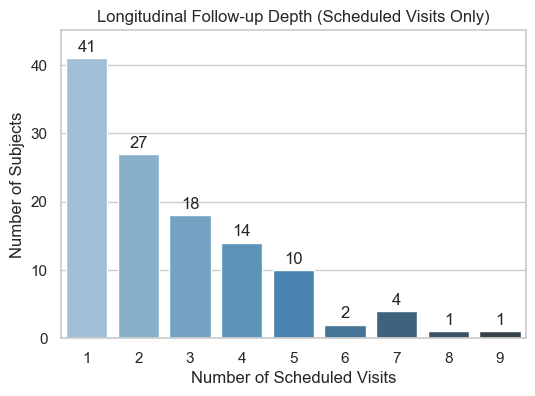

In [42]:
# Map scheduled visits to months and define visit type
df["Visit_Months"] = df["Visit"].map(scheduled_visits)
df["Visit_Type"] = np.where(
    df["Visit"].isin(scheduled_visits.keys()), "Scheduled", "Event"
)

# Keep only scheduled visits
scheduled_df = df[df["Visit_Type"] == "Scheduled"].copy()

# Count unique scheduled visits per subject
visits_per_subject = (
    scheduled_df.groupby("Subject ID", observed=True)["Visit_Months"]
    .nunique()
    .sort_values(ascending=False)
)

# Summary statistics
summary_stats = visits_per_subject.describe()
print("Longitudinal Coverage per Subject (Scheduled Visits):")
display(summary_stats)

# -------------------------------
# Plot barplot with counts on top
# -------------------------------
# Count how many subjects have each number of visits
visit_counts = visits_per_subject.value_counts().sort_index()

plt.figure(figsize=(6, 4))
ax = sns.barplot(x=visit_counts.index, y=visit_counts.values, palette="Blues_d")

# Annotate each bar with the count
for i, v in enumerate(visit_counts.values):
    ax.text(i, v + 0.5, str(v), ha="center", va="bottom")

plt.xlabel("Number of Scheduled Visits")
plt.ylabel("Number of Subjects")
plt.title("Longitudinal Follow-up Depth (Scheduled Visits Only)")
plt.xticks(range(len(visit_counts.index)), visit_counts.index)
plt.ylim(0, visit_counts.values.max() * 1.1)  # Add some space for annotations
plt.show()


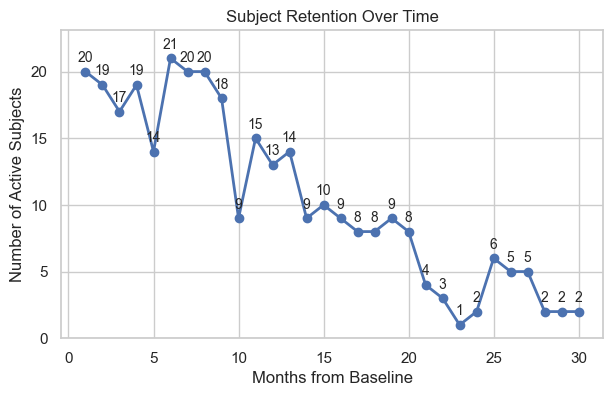

/tmp/ipykernel_46569/2829091273.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=retention.index, y=retention.values, palette="Blues_d")


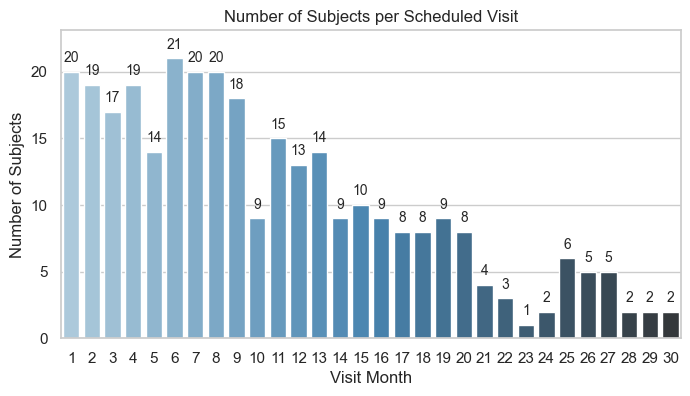

In [43]:
# Compute retention
# the number of unique subjects (Subject ID) present at each scheduled visit month (Visit_Months)
retention = (
    scheduled_df.groupby("Visit_Months", observed=True)["Subject ID"]
    .nunique()
    .sort_index()
)

# -----------------------------
# Line plot with exact numbers
# -----------------------------
plt.figure(figsize=(7, 4))
plt.plot(retention.index, retention.values, marker="o", linewidth=2)

# Annotate each point with the exact number
for x, y in zip(retention.index, retention.values):
    plt.text(x, y + 0.5, str(y), ha="center", va="bottom", fontsize=10)

plt.xlabel("Months from Baseline")
plt.ylabel("Number of Active Subjects")
plt.title("Subject Retention Over Time")
plt.grid(True)
plt.ylim(0, retention.values.max() * 1.1)
plt.show()

# -----------------------------
# Bar plot with exact numbers
# -----------------------------
plt.figure(figsize=(8, 4))
ax = sns.barplot(x=retention.index, y=retention.values, palette="Blues_d")

# Annotate each bar with the exact number
for i, v in enumerate(retention.values):
    ax.text(i, v + 0.5, str(v), ha="center", va="bottom", fontsize=10)

plt.xlabel("Visit Month")
plt.ylabel("Number of Subjects")
plt.title("Number of Subjects per Scheduled Visit")
plt.ylim(0, retention.values.max() * 1.1)
plt.show()